In [1]:
import yt
import ytree
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load ytree arbor and array of redshifts.
a = ytree.load('full_arbor/full_arbor.h5')
redshifts = np.load('stored_arrays/ytree_redshifts.npy')

### Filtering Redshifts

I am not interested in extremely high redshifts since stars haven't formed yet, so here I set a maximum redshift.

I also found that the datasets for some redshifts produced bad data (specifically for the radiation quantities), so I exclude them from my analysis here.

In [4]:
# Set the maximum redshift to be included in analysis.
max_redshift = 12.

# Identify any bad datasets.
bad_redshifts = np.array([redshifts[23], redshifts[30]])
# Create mask to exlude high redshifts and bad redshifts.
mask = (redshifts < max_redshift)*[redshift not in bad_redshifts for redshift in redshifts]

# Update redshift array to include only redshifts of interest.
redshifts = redshifts[mask]

### Determining the Halo Mass Range

I am restricting my analysis to an intermediate mass range within which some halos form stars and some halos don't. There are several ways to determine the appropriate mass range. The two that I tested are:

1. At each redshift, find the minimum mass of star-forming halos and the maximum mass of no-star halos. 
2. Fit a power law mass function to bound the lower mass limit for Pop III forming stars and the upper limit on no-star halos. This method yields coefficients that will be used to calculated the mass range at each redshift.

The first method gives the exact intermediate range at each redshift and is simpler to implement. However the minimum and maximum masses vary greatly between redshifts which introduces some randomness. The second method produces smoother mass boundaries but there is some arbitrariness in deciding what a good fit is.

**If using the first method, run just the next cell and skip the two Power Law Fit cells**. The second method depends on the minimum masses from the first method, so **if using the second method, run all three of the following cells in order**.

In [5]:
##############################################################
# Determine the intermediate mass range at each redshift.
# If running this cell, don't run the next two cells.
##############################################################

# Minimum mass threshold for halo to be considered virialized. Contains ~250 dark matter particles.
min_mass_threshold = 5*10**5
# Arrays to store min and max masses in mass range for each redshift.
# min_mass will be the minimum mass among halos with stars.
# max_mass will be the maximum mass among halos that have no stars.
min_masses = np.zeros(len(redshifts))
max_masses = np.zeros(len(redshifts))

# Iterate through each redshift to determine minimum and maximum masses for the mass range.
for i, redshift in enumerate(redshifts):
    # Load all virialized halos at this redshift.
    hlist = a.select_halos("(tree['tree', 'redshift'] == {}) & (tree['tree', 'mass'] > {})".format(redshift, min_mass_threshold), \
                           fields=['redshift', 'mass'])
    
    N = len(hlist)

    # Arrays of masses of all halos at this redshift.
    masses = np.array([halo['sphere_mass'] for halo in hlist])
    stellar_masses = np.array([halo['sphere_stellar_mass'] for halo in hlist])
    # Create mask to filter all halos that have live star particles.
    # Dead star particles have very low, but non-zero mass, so filter by setting lower mass to 1.
    has_stars = stellar_masses > 1.
    
    # Assign minimum and maximum masses if possible.
    # If there are no halos with stars at this redshift set the min mass to 0.
    try:
        min_masses[i] = np.min(masses[has_stars])
        max_masses[i] = np.max(masses[~has_stars])
    except ValueError:
        min_masses[i] = 0.
        max_masses[i] = np.max(masses[~has_stars])

Selecting halos: 100%|██████████| 4681/4681 [00:00<00:00, 6712.94it/s]


Selecting halos: 100%|██████████| 4681/4681 [00:00<00:00, 9811.82it/s]


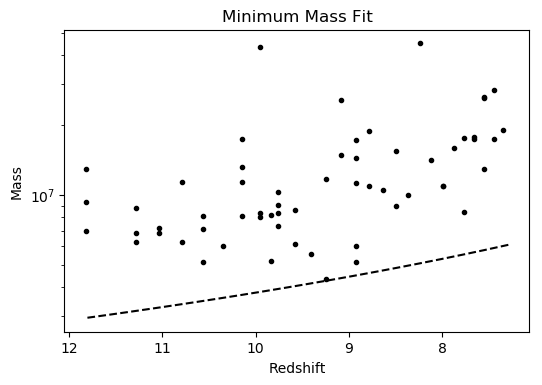

In [15]:
##############################################################
# Minimum Mass Power Law Fit
##############################################################

# Load all Pop III progenitors.
hlist = a.select_halos("(tree['tree', 'redshift'] < {}) & (tree['tree', 'is_popiii_progenitor'] == 1) "\
                       .format(max_redshift), fields=['redshift', 'is_popiii_progenitor'])

# Arrays of the masses and redshifts for each Pop III progenitor
masses = np.array([halo['sphere_mass'] for halo in hlist])
progenitor_redshifts = np.array([halo['redshift'] for halo in hlist])

# The range of redshifts along which to produce the mass fit
redshift_range = np.linspace(np.min(redshifts), np.max(redshifts), 20)

# The mass fit is a power law with a coefficient and an exponent.
# Vary these two parameters to produce a fit that bounds the lower limit of the Pop III progenitors.
min_exponent = -1.5
min_coefficient = 1.2e8

min_mass_fit = min_coefficient*redshift_range**min_exponent

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.semilogy(progenitor_redshifts, masses, 'k.')
plt.semilogy(redshift_range, min_mass_fit, 'k--')
plt.gca().invert_xaxis()
plt.xlabel('Redshift')
plt.ylabel('Mass')
plt.title('Minimum Mass Fit')
plt.show()

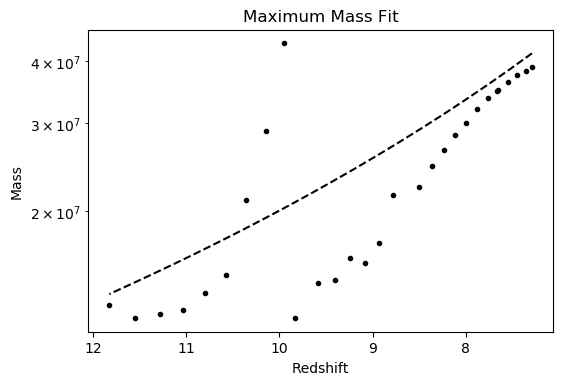

In [7]:
##############################################################
# Maximum Mass Power Law Fit
##############################################################

# The mass fit is a power law with a coefficient and an exponent.
# Vary these two parameters to produce a fit that bounds the upper limit of no-star halos.
max_exponent = -2.3
max_coefficient = 4e9

max_mass_fit = max_coefficient*redshift_range**max_exponent

fig = plt.figure()
fig.patch.set_facecolor('white')
fig.set_dpi(100)

plt.semilogy(redshifts, max_masses, 'k.')
plt.semilogy(redshift_range, max_mass_fit, 'k--')
plt.gca().invert_xaxis()
plt.xlabel('Redshift')
plt.ylabel('Mass')
plt.title('Maximum Mass Fit')
plt.show()

In [19]:
redshift = redshifts[-1]

min_mass = min_coefficient*redshift**min_exponent
max_mass = max_coefficient*redshift**max_exponent

hlist = a.select_halos("(tree['tree', 'redshift'] == {}) & (tree['tree', 'mass'] > {}) \
                            & (tree['tree', 'sphere_mass'] > {}) & (tree['tree', 'sphere_mass'] < {})"\
                           .format(redshift, min_mass_threshold, min_mass, max_mass), fields=['redshift', \
                                                                                              'sphere_mass'])
    
# Arrays to store values of the quantities at this redshift
masses = np.array([halo['sphere_mass'] for halo in hlist])

print(len(masses))
print(type(masses))

Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3088.49it/s]


107
<class 'numpy.ndarray'>


### Determining Interval Ranges

Now that have I have the datasets loaded, the intermediate mass ranges determined, and the redshifts selected, I can determine the interval ranges about the median for each halo quantity of interest. I chose to view the median, the middle 68%, middle 95%, and max and min quantities.

I differentiate between halos with no stars and halos with stars.

The quantities are save in 3-dimensional arrays. The first dimension corresponds to the redshift (in order of increasing time). The second dimension is a label of 1 or 0 for a halo that has stars or a halo that has no stars respectively. The third dimension corresponds to the percentile that is stored.

Example:

I determine the interval ranges from an array of percentiles. My percentiles are stored in an array `percentiles = np.array([0, 2.5, 16., 50., 84., 97.5, 100])`.

`mass[12, 1, 2]` would look at `redshift[12]`, include only halos with stars, and give the 16th percentile (from `percentiles[2]`) of the halo mass.

In [22]:
# Set the percentiles to check for each quantity at each redshift
# Get the median, middle 68%, middle 95%, and max and min values.
percentiles = np.array([0, 2.5, 16., 50., 84., 97.5, 100])

num_redshifts = len(redshifts)

# Arrays for each quantity.
# First dimension corresponds to redshift,
# second corresponds to no-stars/stars,
# third dimension corresponds to percentile.
mass = np.zeros((num_redshifts, 2, len(percentiles)))
stellar_mass = np.zeros((num_redshifts, 2, len(percentiles)))
gas_mass = np.zeros((num_redshifts, 2, len(percentiles)))

mass_growth = np.zeros((num_redshifts, 2, len(percentiles)))
mass_growth_derivative = np.zeros((num_redshifts, 2, len(percentiles)))

stellar_metallicity = np.zeros((num_redshifts, 2, len(percentiles)))
gas_metallicity = np.zeros((num_redshifts, 2, len(percentiles)))

J21_LW = np.zeros((num_redshifts, 2, len(percentiles)))
J_Lyman = np.zeros((num_redshifts, 2, len(percentiles)))

M_thresh = np.zeros((num_redshifts, 2, len(percentiles)))

neighbor_distance = np.zeros((num_redshifts, 2, len(percentiles)))

number_of_mergers = np.zeros((num_redshifts, 2, len(percentiles)))

central_density = np.zeros((num_redshifts, 2, len(percentiles)))
central_H2_fraction = np.zeros((num_redshifts, 2, len(percentiles)))

H2_density = np.zeros((num_redshifts, 2, len(percentiles)))
cooling_rate = np.zeros((num_redshifts, 2, len(percentiles)))

for i, redshift in enumerate(redshifts):
    
    # Set minimum and maximum mass at this redshift
    min_mass = min_coefficient*redshift**min_exponent
    max_mass = max_coefficient*redshift**max_exponent
    
    # Select all halos at the given redshift, above the minimum mass threshold for virialization, and within the
    # intermediate mass range.
    hlist = a.select_halos("(tree['tree', 'redshift'] == {}) & (tree['tree', 'mass'] > {}) \
                            & (tree['tree', 'sphere_mass'] > {}) & (tree['tree', 'sphere_mass'] < {})"\
                           .format(redshift, min_mass_threshold, min_mass, max_mass), fields=['redshift', \
                                                                                              'sphere_mass'])
    
    # Arrays to store values of the quantities at this redshift
    masses = np.array([halo['sphere_mass'] for halo in hlist])
    stellar_masses = np.array([halo['sphere_stellar_mass'] for halo in hlist])
    gas_masses = np.array([halo['sphere_gas_mass'] for halo in hlist])
    growth_rate = np.array([halo['sphere_mass_growth'] for halo in hlist])
    growth_derivative =np.array([halo['sphere_mass_growth_derivative'] for halo in hlist])
    stellar_metals = np.array([halo['sphere_stellar_metal_fraction'] for halo in hlist])
    gas_metals = np.array([halo['sphere_gas_metal_fraction'] for halo in hlist])
    jlw = np.array([halo['sphere_J21_LW'] for halo in hlist])
    jlyman = np.array([halo['sphere_J_Lyman'] for halo in hlist])
    mthresh = np.array([halo['mass_threshold'] for halo in hlist])
    neighbor_distances = np.array([halo['neighbor_distance'] for halo in hlist])
    num_mergers = np.array([halo['number_of_mergers'] for halo in hlist])
    central_densities = np.array([halo['central_density'] for halo in hlist])
    central_H2_fractions = np.array([halo['central_H2_fraction'] for halo in hlist])
    H2_densities = central_densities*central_H2_fractions
    cooling_rates = central_densities**2*central_H2_fractions
            
    # Create mask for halos with live stars.
    # After stars die, their particle mass is reduced but they still exist so we identify halos with live stars by
    # setting a lower stellar mass threshold.
    has_stars = stellar_masses > 1
    
    star_condition = [~has_stars, has_stars]
    
    # Update interval range arrays.
    # First add percentiles for no-star halos, then for halos with stars.
    for j, condition in enumerate(star_condition):
        
        mass[i,j] = np.nanpercentile(masses[condition], percentiles)
        stellar_mass[i,j] = np.nanpercentile(stellar_masses[condition], percentiles)
        gas_mass[i,j] = np.nanpercentile(gas_masses[condition], percentiles)
        
        mass_growth[i,j] = np.nanpercentile(growth_rate[condition], percentiles)
        mass_growth_derivative[i,j] = np.nanpercentile(growth_derivative[condition], percentiles)
        
        stellar_metallicity[i,j] = np.nanpercentile(stellar_metals[condition], percentiles)
        gas_metallicity[i,j] = np.nanpercentile(gas_metals[condition], percentiles)
        
        J21_LW[i,j] = np.nanpercentile(jlw[condition], percentiles)
        J_Lyman[i,j] = np.nanpercentile(jlyman[condition], percentiles)
        
        M_thresh[i,j] = np.nanpercentile(mthresh[condition], percentiles)
        
        neighbor_distance[i,j] = np.nanpercentile(neighbor_distances[condition], percentiles)
        
        number_of_mergers[i,j] = np.nanpercentile(num_mergers[condition], percentiles)
        
        central_density[i,j] = np.nanpercentile(central_densities[condition], percentiles)
        central_H2_fraction[i,j] = np.nanpercentile(central_H2_fractions[condition], percentiles)
        
        H2_density[i,j] = np.nanpercentile(H2_densities[condition], percentiles)
        cooling_rate[i,j] = np.nanpercentile(cooling_rates[condition], percentiles)
    
    print(i)

Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3079.33it/s]


0


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3087.73it/s]


1


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3078.20it/s]


2


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3064.95it/s]


3


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3054.39it/s]


4


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3058.11it/s]


5


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3064.56it/s]


6


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3067.21it/s]


7


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3066.05it/s]


8


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3051.09it/s]


9


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3078.35it/s]


10


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3049.96it/s]


11


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3045.49it/s]


12


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3062.13it/s]


13


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 2884.18it/s]


14


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3071.71it/s]


15


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3070.62it/s]


16


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3081.72it/s]


17


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3079.68it/s]


18


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3079.53it/s]


19


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3079.20it/s]


20


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 2825.43it/s]


21


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3087.39it/s]


22


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3064.90it/s]


23


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3073.73it/s]


24


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3077.97it/s]


25


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3074.68it/s]


26


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3043.20it/s]


27


Selecting halos: 100%|██████████| 4681/4681 [00:01<00:00, 3091.49it/s]


28


### Determining Pop III Halo and Progenitor Halo Properties

There are few enough Pop III halos that I save the quantities for each halo rather than doing a statistical analysis like I did above for the overall halo population. I store the quantities in arrays for each Pop III halo and for each Pop III Progenitor halo. I also store arrays for the redshifts that correspond to each Pop III halo and Pop III Progenitor halo so that they can be plotted together with the rest of the halos.

In [23]:
hlist = a.select_halos("(tree['tree', 'redshift'] < {}) & (tree['tree', 'is_popiii_halo'] == 1)"\
                       .format(max_redshift), fields=['redshift', 'is_popiii_halo'])
popiii_halos = []
for halo in hlist:
    redshift = halo['redshift']
    min_mass = min_coefficient*redshift**min_exponent
    max_mass = max_coefficient*redshift**max_exponent
    halo_mass = halo['sphere_mass']
    if redshift not in bad_redshifts and halo_mass >= min_mass and halo_mass <= max_mass:
        popiii_halos.append(halo)
        
hlist = a.select_halos("(tree['tree', 'redshift'] < {}) & (tree['tree', 'is_popiii_progenitor'] == 1)"\
                       .format(max_redshift), fields=['redshift', 'is_popiii_progenitor'])
progenitors = []
for halo in hlist:
    redshift = halo['redshift']
    min_mass = min_coefficient*redshift**min_exponent
    max_mass = max_coefficient*redshift**max_exponent
    halo_mass = halo['sphere_mass']
    if redshift not in bad_redshifts and halo_mass >= min_mass and halo_mass <= max_mass:
        progenitors.append(halo)

# Initialize arrays for halos with current Pop III stars.
mass_popiii = np.array([halo['sphere_mass'] for halo in popiii_halos])
stellar_mass_popiii = np.array([halo['sphere_stellar_mass'] for halo in popiii_halos])
gas_mass_popiii = np.array([halo['sphere_gas_mass'] for halo in popiii_halos])
mass_growth_popiii = np.array([halo['sphere_mass_growth'] for halo in popiii_halos])
mass_growth_derivative_popiii = np.array([halo['sphere_mass_growth_derivative'] for halo in popiii_halos])
stellar_metallicity_popiii = np.array([halo['sphere_stellar_metal_fraction'] for halo in popiii_halos])
gas_metallicity_popiii = np.array([halo['sphere_gas_metal_fraction'] for halo in popiii_halos])
J21_LW_popiii = np.array([halo['sphere_J21_LW'] for halo in popiii_halos])
J_Lyman_popiii = np.array([halo['sphere_J_Lyman'] for halo in popiii_halos])
M_thresh_popiii = np.array([halo['mass_threshold'] for halo in popiii_halos])
neighbor_distance_popiii = np.array([halo['neighbor_distance'] for halo in popiii_halos])
number_of_mergers_popiii = np.array([halo['number_of_mergers'] for halo in popiii_halos])
central_density_popiii = np.array([halo['central_density'] for halo in popiii_halos])
central_H2_fraction_popiii = np.array([halo['central_H2_fraction'] for halo in popiii_halos])
H2_density_popiii = central_density_popiii*central_H2_fraction_popiii
cooling_rate_popiii = central_density_popiii**2*central_H2_fraction_popiii
redshifts_popiii = np.array([halo['redshift'] for halo in popiii_halos])

# Initialize arrays for the progenitors of halos with Pop III stars
mass_popiii_prog = np.array([halo['sphere_mass'] for halo in progenitors])
stellar_mass_popiii_prog = np.array([halo['sphere_stellar_mass'] for halo in progenitors])
gas_mass_popiii_prog = np.array([halo['sphere_gas_mass'] for halo in progenitors])
mass_growth_popiii_prog = np.array([halo['sphere_mass_growth'] for halo in progenitors])
mass_growth_derivative_popiii_prog = np.array([halo['sphere_mass_growth_derivative'] for halo in progenitors])
stellar_metallicity_popiii_prog = np.array([halo['sphere_stellar_metal_fraction'] for halo in progenitors])
gas_metallicity_popiii_prog = np.array([halo['sphere_gas_metal_fraction'] for halo in progenitors])
J21_LW_popiii_prog = np.array([halo['sphere_J21_LW'] for halo in progenitors])
J_Lyman_popiii_prog = np.array([halo['sphere_J_Lyman'] for halo in progenitors])
M_thresh_popiii_prog = np.array([halo['mass_threshold'] for halo in progenitors])
neighbor_distance_popiii_prog = np.array([halo['neighbor_distance'] for halo in progenitors])
number_of_mergers_popiii_prog = np.array([halo['number_of_mergers'] for halo in progenitors])
central_density_popiii_prog = np.array([halo['central_density'] for halo in progenitors])
central_H2_fraction_popiii_prog = np.array([halo['central_H2_fraction'] for halo in progenitors])
H2_density_popiii_prog = central_density_popiii_prog*central_H2_fraction_popiii_prog
cooling_rate_popiii_prog = central_density_popiii_prog**2*central_H2_fraction_popiii_prog
redshifts_popiii_prog = np.array([halo['redshift'] for halo in progenitors])

Selecting halos: 100%|██████████| 4681/4681 [00:00<00:00, 9854.68it/s]


"\nnum_popiii = len(popiii_halos)\nnum_progenitors = len(progenitors)\n\nmass_popiii = np.zeros(num_popiii)\nstellar_mass_popiii = np.zeros(num_popiii)\ngas_mass_popiii = np.zeros(num_popiii)\nmass_growth_popiii = np.zeros(num_popiii)\nmass_growth_derivative_popiii = np.zeros(num_popiii)\nstellar_metallicity_popiii = np.zeros(num_popiii)\ngas_metallicity_popiii = np.zeros(num_popiii)\nJ21_LW_popiii = np.zeros(num_popiii)\nJ_Lyman_popiii = np.zeros(num_popiii)\nM_thresh_popiii = np.zeros(num_popiii)\nneighbor_distance_popiii = np.zeros(num_popiii)\nnumber_of_mergers_popiii = np.zeros(num_popiii)\ncentral_density_popiii = np.zeros(num_popiii)\ncentral_H2_fraction_popiii = np.zeros(num_popiii)\nH2_density_popiii = np.zeros(num_popiii)\nH2_density2_popiii = np.zeros(num_popiii)\nredshifts_popiii = np.zeros(num_popiii)\n\n# Initialize arrays for the progenitors of halos with Pop III stars\nmass_popiii_prog = np.zeros(num_progenitors)\nstellar_mass_popiii_prog = np.zeros(num_progenitors)\nga

### Save and Load Data

The following two cells are just for saving and reloading the arrays for convenience for later use.

In [25]:
# Save data for future use.
np.save('redshift_plots/arrays/mass', mass)
np.save('redshift_plots/arrays/stellar_mass', stellar_mass)
np.save('redshift_plots/arrays/gas_mass', gas_mass)
np.save('redshift_plots/arrays/mass_growth', mass_growth)
np.save('redshift_plots/arrays/mass_growth_derivative', mass_growth_derivative)
np.save('redshift_plots/arrays/stellar_metallicity', stellar_metallicity)
np.save('redshift_plots/arrays/gas_metallicity', gas_metallicity)
np.save('redshift_plots/arrays/J21_LW', J21_LW)
np.save('redshift_plots/arrays/J_Lyman', J_Lyman)
np.save('redshift_plots/arrays/M_thresh', M_thresh)
np.save('redshift_plots/arrays/neighbor_distance', neighbor_distance)
np.save('redshift_plots/arrays/number_of_mergers', number_of_mergers)
np.save('redshift_plots/arrays/central_density', central_density)
np.save('redshift_plots/arrays/central_H2_fraction', central_H2_fraction)
np.save('redshift_plots/arrays/H2_density', H2_density)
np.save('redshift_plots/arrays/cooling_rate', cooling_rate)

np.save('redshift_plots/arrays/mass_popiii', mass_popiii)
np.save('redshift_plots/arrays/stellar_mass_popiii', stellar_mass_popiii)
np.save('redshift_plots/arrays/gas_mass_popiii', gas_mass_popiii)
np.save('redshift_plots/arrays/mass_growth_popiii', mass_growth_popiii)
np.save('redshift_plots/arrays/mass_growth_derivative_popiii', mass_growth_derivative_popiii)
np.save('redshift_plots/arrays/stellar_metallicity_popiii', stellar_metallicity_popiii)
np.save('redshift_plots/arrays/gas_metallicity_popiii', gas_metallicity_popiii)
np.save('redshift_plots/arrays/J21_LW_popiii', J21_LW_popiii)
np.save('redshift_plots/arrays/J_Lyman_popiii', J_Lyman_popiii)
np.save('redshift_plots/arrays/M_thresh_popiii', M_thresh_popiii)
np.save('redshift_plots/arrays/neighbor_distance_popiii', neighbor_distance_popiii)
np.save('redshift_plots/arrays/number_of_mergers_popiii', number_of_mergers_popiii)
np.save('redshift_plots/arrays/central_density_popiii', central_density_popiii)
np.save('redshift_plots/arrays/central_H2_fraction_popiii', central_H2_fraction_popiii)
np.save('redshift_plots/arrays/H2_density_popiii', H2_density_popiii)
np.save('redshift_plots/arrays/cooling_rate_popiii', cooling_rate_popiii)
np.save('redshift_plots/arrays/redshifts_popiii', redshifts_popiii)

np.save('redshift_plots/arrays/mass_popiii_prog', mass_popiii_prog)
np.save('redshift_plots/arrays/stellar_mass_popiii_prog', stellar_mass_popiii_prog)
np.save('redshift_plots/arrays/gas_mass_popiii_prog', gas_mass_popiii_prog)
np.save('redshift_plots/arrays/mass_growth_popiii_prog', mass_growth_popiii_prog)
np.save('redshift_plots/arrays/mass_growth_derivative_popiii_prog', mass_growth_derivative_popiii_prog)
np.save('redshift_plots/arrays/stellar_metallicity_popiii_prog', stellar_metallicity_popiii_prog)
np.save('redshift_plots/arrays/gas_metallicity_popiii_prog', gas_metallicity_popiii_prog)
np.save('redshift_plots/arrays/J21_LW_popiii_prog', J21_LW_popiii_prog)
np.save('redshift_plots/arrays/J_Lyman_popiii_prog', J_Lyman_popiii_prog)
np.save('redshift_plots/arrays/M_thresh_popiii_prog', M_thresh_popiii_prog)
np.save('redshift_plots/arrays/neighbor_distance_popiii_prog', neighbor_distance_popiii_prog)
np.save('redshift_plots/arrays/number_of_mergers_popiii_prog', number_of_mergers_popiii_prog)
np.save('redshift_plots/arrays/central_density_popiii_prog', central_density_popiii_prog)
np.save('redshift_plots/arrays/central_H2_fraction_popiii_prog', central_H2_fraction_popiii_prog)
np.save('redshift_plots/arrays/H2_density_popiii_prog', H2_density_popiii_prog)
np.save('redshift_plots/arrays/cooling_rate_popiii_prog', cooling_rate_popiii_prog)
np.save('redshift_plots/arrays/redshifts_popiii_prog', redshifts_popiii_prog)

In [18]:
# Load previously saved data.
mass = np.load('redshift_plots/arrays/mass.npy')
stellar_mass = np.load('redshift_plots/arrays/stellar_mass.npy')
gas_mass = np.load('redshift_plots/arrays/gas_mass.npy')
mass_growth = np.load('redshift_plots/arrays/mass_growth.npy')
mass_growth_derivative = np.load('redshift_plots/arrays/mass_growth_derivative.npy')
stellar_metallicity = np.load('redshift_plots/arrays/stellar_metallicity.npy')
gas_metallicity = np.load('redshift_plots/arrays/gas_metallicity.npy')
J21_LW = np.load('redshift_plots/arrays/J21_LW.npy')
J_Lyman = np.load('redshift_plots/arrays/J_Lyman.npy')
M_thresh = np.load('redshift_plots/arrays/M_thresh.npy')
neighbor_distance = np.load('redshift_plots/arrays/neighbor_distance.npy')
number_of_mergers = np.load('redshift_plots/arrays/number_of_mergers.npy')
central_density = np.load('redshift_plots/arrays/central_density.npy')
central_H2_fraction = np.load('redshift_plots/arrays/central_H2_fraction.npy')
H2_density = np.load('redshift_plots/arrays/H2_density.npy')
cooling_rate = np.load('redshift_plots/arrays/cooling_rate.npy')

mass_popiii = np.load('redshift_plots/arrays/mass_popiii.npy')
stellar_mass_popiii = np.load('redshift_plots/arrays/stellar_mass_popiii.npy')
gas_mass_popiii = np.load('redshift_plots/arrays/gas_mass_popiii.npy')
mass_growth_popiii = np.load('redshift_plots/arrays/mass_growth_popiii.npy')
mass_growth_derivative_popiii = np.load('redshift_plots/arrays/mass_growth_derivative_popiii.npy')
stellar_metallicity_popiii = np.load('redshift_plots/arrays/stellar_metallicity_popiii.npy')
gas_metallicity_popiii = np.load('redshift_plots/arrays/gas_metallicity_popiii.npy')
J21_LW_popiii = np.load('redshift_plots/arrays/J21_LW_popiii.npy')
J_Lyman_popiii = np.load('redshift_plots/arrays/J_Lyman_popiii.npy')
M_thresh_popiii = np.load('redshift_plots/arrays/M_thresh_popiii.npy')
neighbor_distance_popiii = np.load('redshift_plots/arrays/neighbor_distance_popiii.npy')
number_of_mergers_popiii = np.load('redshift_plots/arrays/number_of_mergers_popiii.npy')
redshifts_popiii = np.load('redshift_plots/arrays/redshifts_popiii.npy')
central_density_popiii = np.load('redshift_plots/arrays/central_density_popiii.npy')
central_H2_fraction_popiii = np.load('redshift_plots/arrays/central_H2_fraction_popiii.npy')
H2_density_popiii = np.load('redshift_plots/arrays/H2_density_popiii.npy')
cooling_rate_popiii = np.load('redshift_plots/arrays/cooling_rate_popiii.npy')

mass_popiii_prog = np.load('redshift_plots/arrays/mass_popiii_prog.npy')
stellar_mass_popiii_prog = np.load('redshift_plots/arrays/stellar_mass_popiii_prog.npy')
gas_mass_popiii_prog = np.load('redshift_plots/arrays/gas_mass_popiii_prog.npy')
mass_growth_popiii_prog = np.load('redshift_plots/arrays/mass_growth_popiii_prog.npy')
mass_growth_derivative_popiii_prog = np.load('redshift_plots/arrays/mass_growth_derivative_popiii_prog.npy')
stellar_metallicity_popiii_prog = np.load('redshift_plots/arrays/stellar_metallicity_popiii_prog.npy')
gas_metallicity_popiii_prog = np.load('redshift_plots/arrays/gas_metallicity_popiii_prog.npy')
J21_LW_popiii_prog = np.load('redshift_plots/arrays/J21_LW_popiii_prog.npy')
J_Lyman_popiii_prog = np.load('redshift_plots/arrays/J_Lyman_popiii_prog.npy')
M_thresh_popiii_prog = np.load('redshift_plots/arrays/M_thresh_popiii_prog.npy')
neighbor_distance_popiii_prog = np.load('redshift_plots/arrays/neighbor_distance_popiii_prog.npy')
number_of_mergers_popiii_prog = np.load('redshift_plots/arrays/number_of_mergers_popiii_prog.npy')
redshifts_popiii_prog = np.load('redshift_plots/arrays/redshifts_popiii_prog.npy')
central_density_popiii_prog = np.load('redshift_plots/arrays/central_density_popiii_prog.npy')
central_H2_fraction_popiii_prog = np.load('redshift_plots/arrays/central_H2_fraction_popiii_prog.npy')
H2_density_popiii_prog = np.load('redshift_plots/arrays/H2_density_popiii_prog.npy')
cooling_rate_popiii_prog = np.load('redshift_plots/arrays/cooling_rate_popiii_prog.npy')

In [28]:
def redshift_plot(z, quantity, z_popiii=[], popiii_quantity=[], z_popiii_prog=[], popiii_prog_quantity=[], \
                  show_stars=False, show_no_stars=True, show_popiii=False, show_popiii_prog=True, xlabel='', \
                  ylabel='', title='', saveas=None, log_scale=True):
    '''
    Produces a plot of the statistics of the given quantity. Plots the median, two interveral ranges, and max and 
    min values. Interval ranges are shaded. Can distinguish between halos with stars and halos with no stars. Can
    plot points for each Pop III halo and Pop III progenitor halo.
    
    By default only plots no-star halos and Pop III progenitor halos.
    
    Arguments:
    z - 1D array of redshifts
    quantity - 3D array of the percentile values for the quantity of interest
    z_popiii - 1D array of redshifts for each of the popiii halos
    popiii_quantity - 1D array of values for the quantity of interest of each Pop III halo
    z_popiii_prog - 1D array of redshifts for each of the popiii progenitors
    popiii_prog_quantity - 1D array of values for the quantity of interest of each Pop III progenitor
    show_stars - boolean
                 Determines whether halos with stars will be plotted
    show_no_stars - boolean
                    Determines whether halos with no stars will be plotted
    show_popiii - boolean
                  Determines whether Pop III halos will be plotted
    show_popiii_prog - boolean
                       Determines whether Pop III progenitor halos will be plotted
    xlabel - string
             Optional name for the x-axis
    ylabel - string
             Optional name for the y-axis
    title - string
            Optional title for the plot
    saveas - string
             File name to be saved as.
             If left as None, the file will not be saved but will still be shown
    log_scale - bool
                Determines whether the y-axis will be log-scale or not
    '''
    
    if show_no_stars == True:
        min_none = quantity[:,0,0]
        low1_none = quantity[:,0,1]
        low2_none = quantity[:,0,2]
        med_none = quantity[:,0,3]
        high1_none = quantity[:,0,4]
        high2_none = quantity[:,0,5]
        max_none = quantity[:,0,6]

    if show_stars == True:
        min_stars = quantity[:,1,0]
        low1_stars = quantity[:,1,1]
        low2_stars = quantity[:,1,2]
        med_stars = quantity[:,1,3]
        high1_stars = quantity[:,1,4]
        high2_stars = quantity[:,1,5]
        max_stars = quantity[:,1,6]

    fig = plt.figure()
    fig.patch.set_facecolor('white')
    fig.set_dpi(100)

    # Plot intervals for no-star halos.
    if show_no_stars == True:
        if log_scale == True:
            plt.semilogy(z, min_none, 'k--')
            plt.semilogy(z, low1_none, 'b--')
            plt.semilogy(z, low2_none, 'b--')
            plt.semilogy(z, high1_none, 'b--')
            plt.semilogy(z, high2_none, 'b--')
            plt.semilogy(z, max_none, 'k--')
            plt.semilogy(z, med_none, 'b-', label='No Stars')
        else:
            plt.plot(z, min_none, 'k--')
            plt.plot(z, low1_none, 'b--')
            plt.plot(z, low2_none, 'b--')
            plt.plot(z, high1_none, 'b--')
            plt.plot(z, high2_none, 'b--')
            plt.plot(z, max_none, 'k--')
            plt.plot(z, med_none, 'b-', label='No Stars')
        
        plt.fill_between(z, low1_none, high2_none, facecolor='blue', alpha=0.3)
        plt.fill_between(z, low2_none, high1_none, facecolor='blue', alpha=0.5)
        
    # Plot intervals for halos with stars.
    if show_stars == True:
        if log_scale == True:
            plt.semilogy(z, min_stars, 'k--')
            plt.semilogy(z, low1_stars, 'y--')
            plt.semilogy(z, low2_stars, 'y--')
            plt.semilogy(z, high1_stars, 'y--')
            plt.semilogy(z, high2_stars, 'y--')
            plt.semilogy(z, max_stars, 'k--')
            plt.semilogy(z, med_stars, 'y-', label='Stars')
        else:
            plt.plot(z, min_stars, 'k--')
            plt.plot(z, low1_stars, 'y--')
            plt.plot(z, low2_stars, 'y--')
            plt.plot(z, high1_stars, 'y--')
            plt.plot(z, high2_stars, 'y--')
            plt.plot(z, max_stars, 'k--')
            plt.plot(z, med_stars, 'y-', label='Stars')
        
        plt.fill_between(z, low1_stars, high2_stars, facecolor='yellow', alpha=0.3)
        plt.fill_between(z, low2_stars, high1_stars, facecolor='yellow', alpha=0.5)
        
    # Plot quantities for all Pop III halos.
    if show_popiii == True:
        plt.scatter(z_popiii, popiii_quantity, marker='.', color='green', label='Pop III')
    # Plot quantities for all Pop III progenitor halos.
    if show_popiii_prog == True:
        plt.scatter(z_popiii_prog, popiii_prog_quantity, marker='.', color='red', label='Pop III Progenitor')

    # Invert the x-axis for increasing time from left to right.
    plt.gca().invert_xaxis()
    plt.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if saveas != None:
        plt.savefig('redshift_plots/plots/'+saveas)
    plt.show()

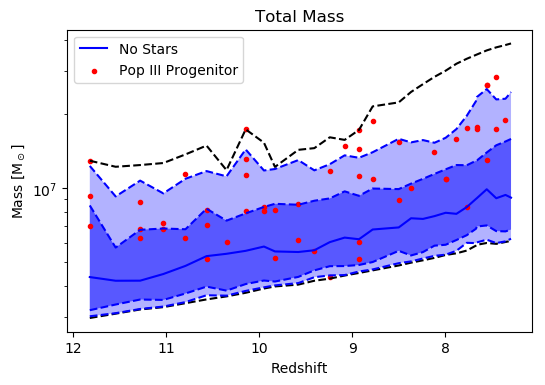

/mnt/home/graceju1/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


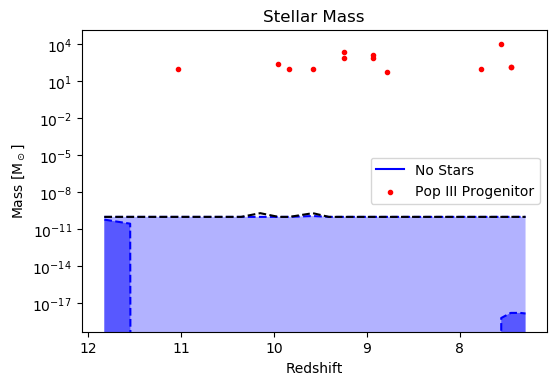

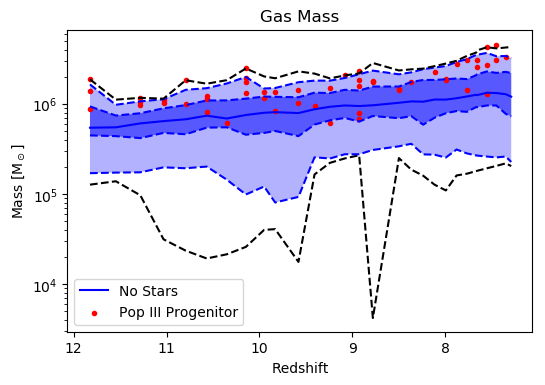

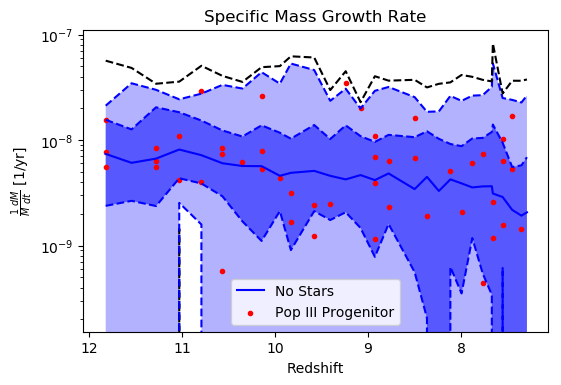

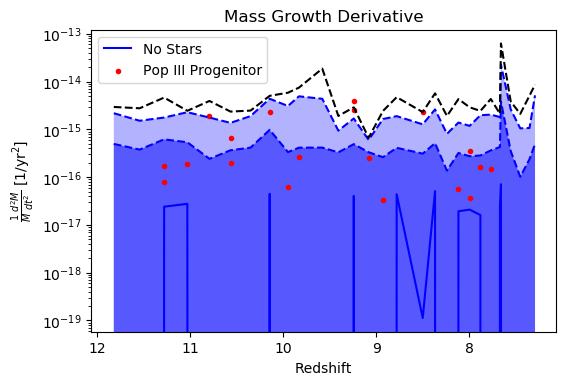

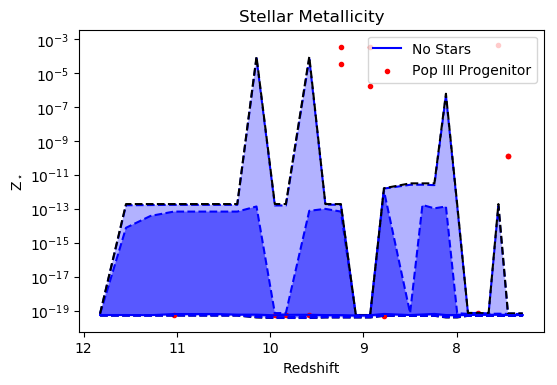

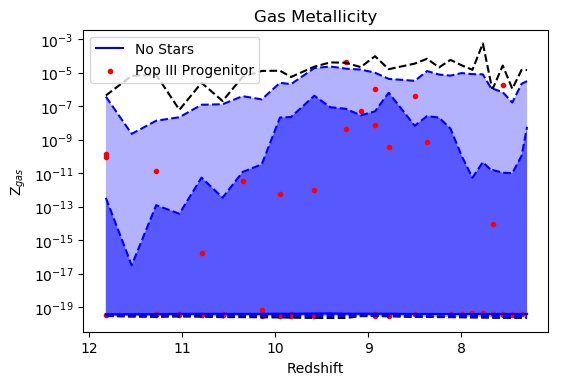

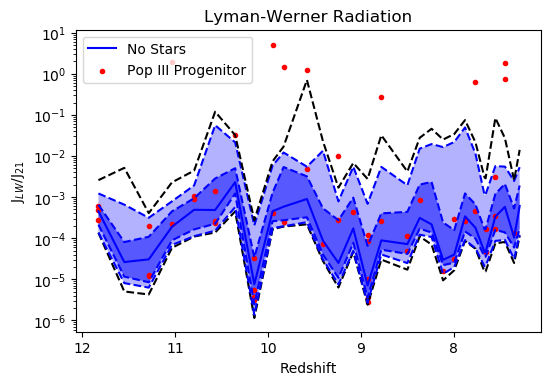

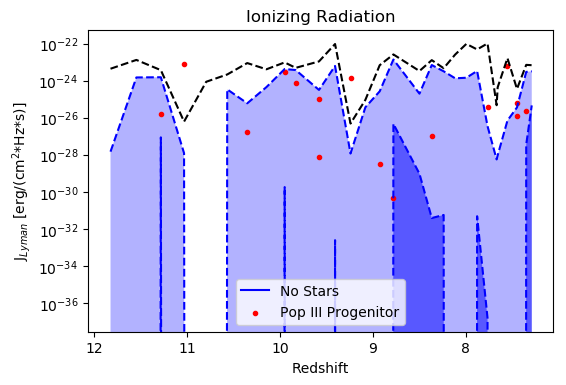

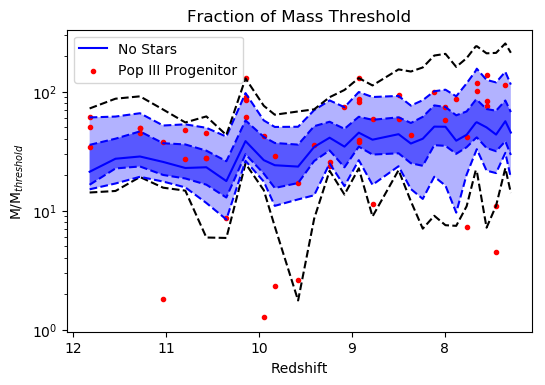

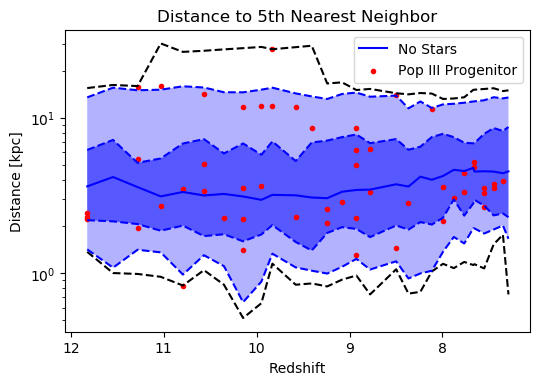

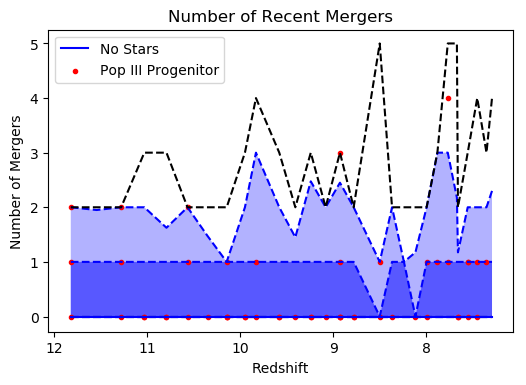

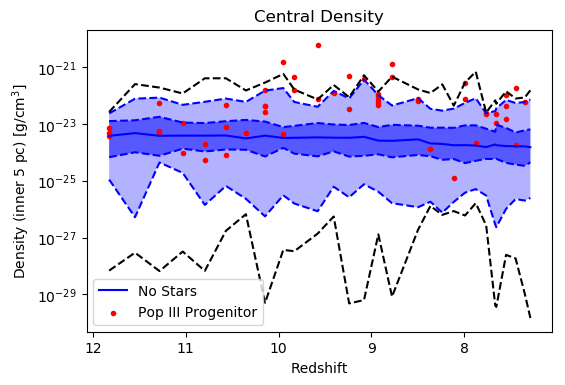

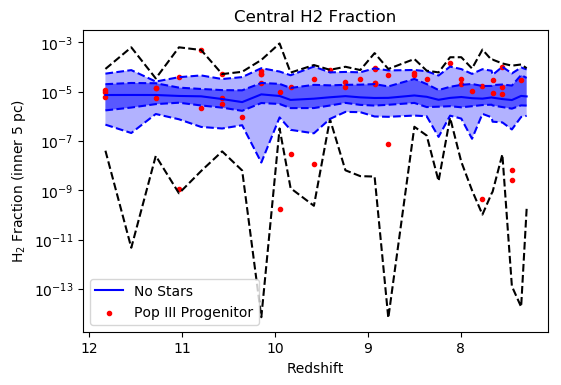

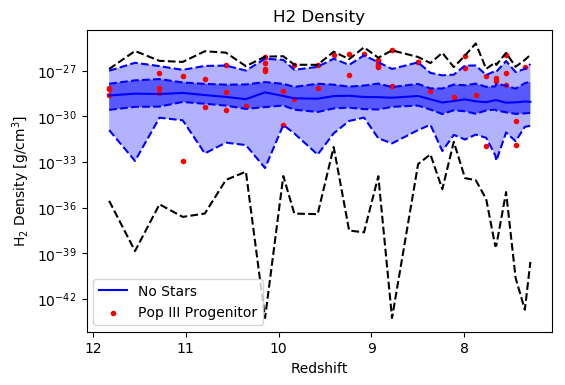

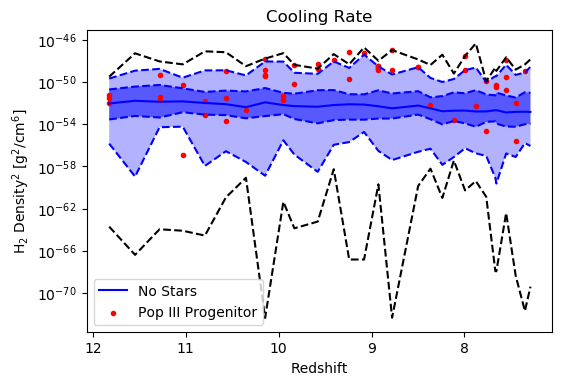

In [29]:
# Produce plots for all quantities. 

quantity = [mass, stellar_mass, gas_mass, mass_growth, mass_growth_derivative, stellar_metallicity, \
            gas_metallicity, J21_LW, J_Lyman, M_thresh, neighbor_distance, number_of_mergers, central_density, \
            central_H2_fraction, H2_density, cooling_rate]
quantity_popiii = [mass_popiii, stellar_mass_popiii, gas_mass_popiii, mass_growth_popiii, \
                   mass_growth_derivative_popiii, stellar_metallicity_popiii, gas_metallicity_popiii, \
                   J21_LW_popiii, J_Lyman_popiii, M_thresh_popiii, neighbor_distance_popiii, \
                   number_of_mergers_popiii, central_density_popiii, central_H2_fraction_popiii, \
                   H2_density_popiii, cooling_rate_popiii]
quantity_popiii_prog = [mass_popiii_prog, stellar_mass_popiii_prog, gas_mass_popiii_prog, \
                        mass_growth_popiii_prog, mass_growth_derivative_popiii_prog, \
                        stellar_metallicity_popiii_prog, gas_metallicity_popiii_prog, J21_LW_popiii_prog, \
                        J_Lyman_popiii_prog, M_thresh_popiii_prog, neighbor_distance_popiii_prog, \
                        number_of_mergers_popiii_prog, central_density_popiii_prog, \
                        central_H2_fraction_popiii_prog, H2_density_popiii_prog, cooling_rate_popiii_prog]
y_label = [r'Mass [M$_\odot$]', r'Mass [M$_\odot]$', r'Mass [M$_\odot]$', r'$\frac{1}{M} \frac{dM}{dt}$ [1/yr]', \
           r'$\frac{1}{M} \frac{d^2M}{dt^2}$ [1/yr$^2$]', r'Z$_\star$', r'Z$_{gas}$', r'J$_{LW}$/J$_{21}$', \
           r'J$_{Lyman}$ [erg/(cm$^2$*Hz*s)]', r'M/M$_{threshold}$', 'Distance [kpc]', 'Number of Mergers', \
           r'Density (inner 5 pc) [g/cm$^3$]', r'H$_2$ Fraction (inner 5 pc)', r'H$_2$ Density [g/cm$^3$]', \
           r'H$_2$ Density$^2$ [g$^2$/cm$^6$]']
title = ['Total Mass', 'Stellar Mass', 'Gas Mass', 'Specific Mass Growth Rate', 'Mass Growth Derivative', \
         'Stellar Metallicity', 'Gas Metallicity', 'Lyman-Werner Radiation', 'Ionizing Radiation', \
         'Fraction of Mass Threshold', 'Distance to 5th Nearest Neighbor', 'Number of Recent Mergers', \
         'Central Density', 'Central H2 Fraction', 'H2 Density', 'Cooling Rate']
filename = ['total_mass', 'stellar_mass', 'gas_mass', 'mass_growth', 'mass_growth_derivative', \
            'stellar_metallicity', 'gas_metallicity', 'J21_LW', 'J_Lyman', 'mass_threshold', \
            'neighbor_distance', 'number_of_mergers', 'central_density', 'central_H2_fraction', 'H2_density', \
            'cooling_rate']

for i in range(len(quantity)):
    if title[i] == 'Number of Recent Mergers':
        redshift_plot(redshifts, quantity[i], z_popiii=redshifts_popiii, popiii_quantity=quantity_popiii[i], \
                      z_popiii_prog=redshifts_popiii_prog, popiii_prog_quantity=quantity_popiii_prog[i], \
                      xlabel='Redshift', ylabel=y_label[i], saveas=filename[i], title=title[i], log_scale=False)
    else:
        redshift_plot(redshifts, quantity[i], z_popiii=redshifts_popiii, popiii_quantity=quantity_popiii[i], \
                      z_popiii_prog=redshifts_popiii_prog, popiii_prog_quantity=quantity_popiii_prog[i], \
                      xlabel='Redshift', ylabel=y_label[i], saveas=filename[i], title=title[i])